In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# Pyspark - SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit

# Pyspark - ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

### 데이터 로드

- Pyspark에서 데이터 로드할 때는 ``os.chdir()``로 디렉토리명 바꾸어도 적용이 안됨!

In [3]:
spark = SparkSession.builder\
        .appName('Play with pypsark ML on Titanic Data')\
        .getOrCreate()

df = spark.read.csv('/Users/younghun/Desktop/gitrepo/data/titanic/train.csv', header=True, inferSchema=True)

In [5]:
# toPandas()를 이용해 판다스에서 제공하는 데이터프레임 형태로 출력
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [6]:
# 데이터 스키마 살펴보기
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



### 데이터 시각화
- Matplotlib, Seaborn 등을 이용하려면 ``SparkDataFrame``➡️``PandasDataFrame``으로 변경해주고 수행해야 함!

In [7]:
pandas_df = df.toPandas()
print("pandas_df 타입:", type(pandas_df))

pandas_df 타입: <class 'pandas.core.frame.DataFrame'>


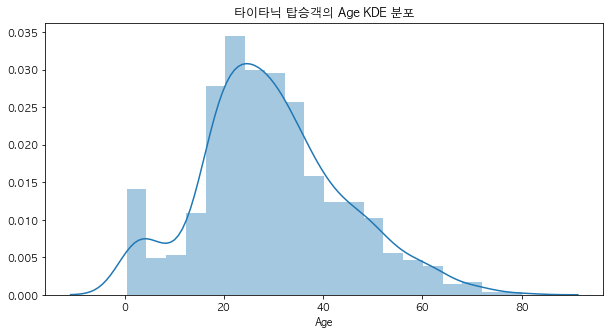

In [13]:
# Seaborn 사용해보기
plt.figure(figsize=(10, 5))
plt.title("타이타닉 탑승객의 Age KDE 분포")
sns.distplot(pandas_df['Age'])
plt.show()

### Pyspark에서 결측치 체크하기

- 결측치 체크하는 방법
    * 1. ``isnan()``: ``pyspark.sql.functions`` 패키지에 속함
        * ``isnan(column)``: 결측치가 존재하는 변수인지 체크하기 위함
    * 2. ``isNull()``: ``pyspark.sql.Column`` 패키지에 속함
        * ``isNull()``은 아무런 변수 넣지 않음
<br><br>
- ``when(조건, 조건 True시 value출력).otherwise(앞의 조건 False시 value출력)``
    * 조건에 여러 조건을 달려면 논리연산자 ``|``, ``&`` 사용 가능

In [16]:
# 위 2가지 방법을 동시에 사용해보자!
# 결측치가 있는 변수를 체크하고 결측치가 몇 개 있는지 살펴보기
from pyspark.sql.functions import isnan, count

# [count~] 부분은 list comprehension이 아니라 select([column]) 부분임!
# [count(~~) 변수를 'c'라는 변수로 alias하는 것임!] 
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])\
  .show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



- 변수 삭제하는 법
    * ``df.drop('column')`` 단, inplace=False이기 때문에 재할당 해주어야 함!

In [17]:
# Cabin 변수는 결측치가 50%가 넘기 때문에 해당 변수를 삭제하자
df = df.drop('Cabin')

- 연령의 결측치 대체하기
- 그런데, 승객들의 이름 앞에 ``Mr, Mrs``와 같은 salutation들이 존재하므로 이것을 기준으로 분할하고 각각의 평균값을 결측치 대체값으로 넣어주기
- Pyspark에서 제공하는 정규표현식 API 이용
    * ``regexp_extract(col('칼럼'), "정규표현식",

In [36]:
df = df.withColumn("Initial", regexp_extract(col("Name"),
                                            "([A-Za-z]+)\.", # ()이게 하나의 그룹임!
                                            1)) # 그룹 인덱스는 1부터!
df.limit(3).show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+



- 오탈자 대체하기
    * ``df.replace([오탈자], [수정된 글자])``

- ``collect()``: 적은 양의 데이터셋을 retrieve할 때!(큰 데이터셋은 메모리 에러 발생). ``select()``와 유사한 기능
    * 보통 ``filter()``, ``group()``, ``count()`` 후 사용
    * ``collect()``로 아무것도 넣지않으면 데이터프레임의 모든 row를 반환
    * 하지만 dataframe형태로 반환하지 않음. , pyspark Row타입의 데이터가 담긴 list를 반환하는데 이를 loop 사용가능함!

In [37]:
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Initial 변수 값들로 그룹핑한 후 평균 Age 구하기
df.groupby('Initial').avg('Age').collect()


[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [40]:
test = df.groupby('Initial').avg('Age').collect()
print(type(test), type(test[0]))

<class 'list'> <class 'pyspark.sql.types.Row'>
